# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings('ignore')

In [2]:
BUDGET = 1e+07
POINTS = 500
BEST_POINTS = 200
PRICE_PER_BARREL = 450
RANDOM_STATE = 12345

Для каждого региона создаём отдельный датафрейм

In [3]:
geo_data_0 = pd.read_csv('datasets/geo_data_0.csv')
geo_data_0.info()
geo_data_0.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


0

In [5]:
geo_data_1 = pd.read_csv('datasets/geo_data_1.csv')
geo_data_1.info()
geo_data_1.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


0

In [6]:
geo_data_2 = pd.read_csv('datasets/geo_data_2.csv')
geo_data_2.info()
geo_data_2.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


0

Пропуски и явные дубликаты в датафреймах отсутствуют

In [7]:
geo_data_0['id'].value_counts().loc[lambda x : x > 1]

fiKDv    2
QcMuo    2
AGS9W    2
Tdehs    2
74z30    2
A5aEY    2
bsk9y    2
TtcGQ    2
HZww2    2
bxg6G    2
Name: id, dtype: int64

In [8]:
geo_data_1['id'].value_counts().loc[lambda x : x > 1]

wt4Uk    2
LHZR0    2
5ltQ6    2
bfPNe    2
Name: id, dtype: int64

In [9]:
geo_data_2['id'].value_counts().loc[lambda x : x > 1]

VF7Jo    2
KUPhW    2
xCHr8    2
Vcm5J    2
Name: id, dtype: int64

Столбец id не нужен для исследования, его можно убрать из всех датафреймов

In [10]:
geo_data_0 = geo_data_0.drop(['id'], axis=1)
geo_data_1 = geo_data_1.drop(['id'], axis=1)
geo_data_2 = geo_data_2.drop(['id'], axis=1)

Проверим наличие нулевых значений в целевом признаке

In [11]:
def check_zeros(df, target):
    zeros = df[df[target] == 0][target].count()
    percent = zeros / df.shape[0]
    print('Количество нулевых значений -', zeros)
    print('Доля нулевых значений -', percent)

In [12]:
check_zeros(geo_data_0, 'product')

Количество нулевых значений - 1
Доля нулевых значений - 1e-05


In [13]:
check_zeros(geo_data_1, 'product')

Количество нулевых значений - 8235
Доля нулевых значений - 0.08235


In [14]:
check_zeros(geo_data_2, 'product')

Количество нулевых значений - 1
Доля нулевых значений - 1e-05


По региону 1 8.235% значений в целевом признаке имеют нулевое значение. В сравнении с другими регионами, можно предположить, что данные были утеряны или вовсе не исследованы

Изучим гистограммы по целевому признаку

In [15]:
def product_hist(product, bins, xlim_max, ylim_max):
    plt.figure(figsize=[10,7])

    plt.hist(product, bins=bins)

    plt.xlim([0,xlim_max])
    plt.ylim([0,ylim_max])

    plt.xlabel("Объем нефти на скважину, тыс. барелей")
    plt.ylabel("Количество скважин")

    plt.title("Гистограмма распределения по объему скважин")
    plt.show()

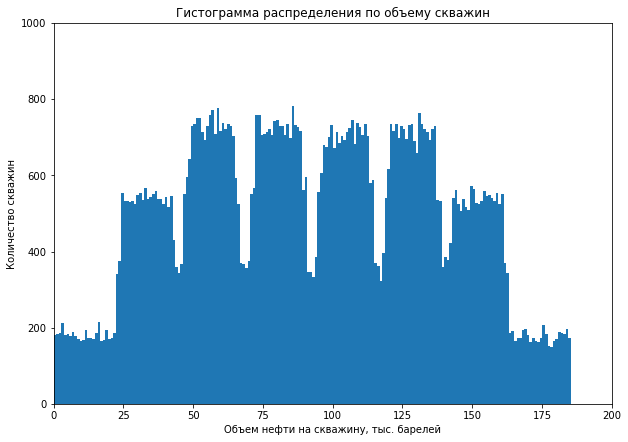

In [16]:
product_hist(geo_data_0['product'], 200, 200, 1000)

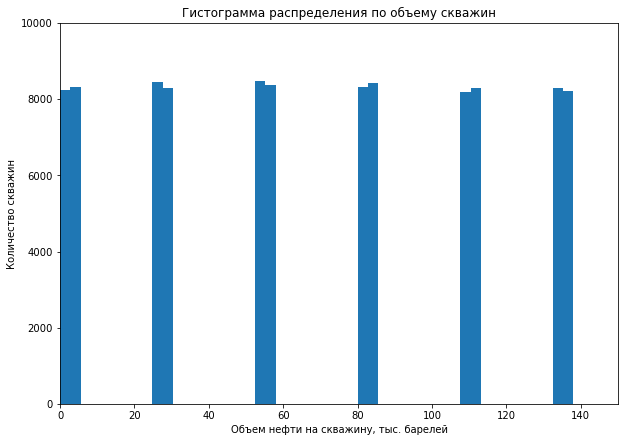

In [17]:
product_hist(geo_data_1['product'], 50, 150, 10000)

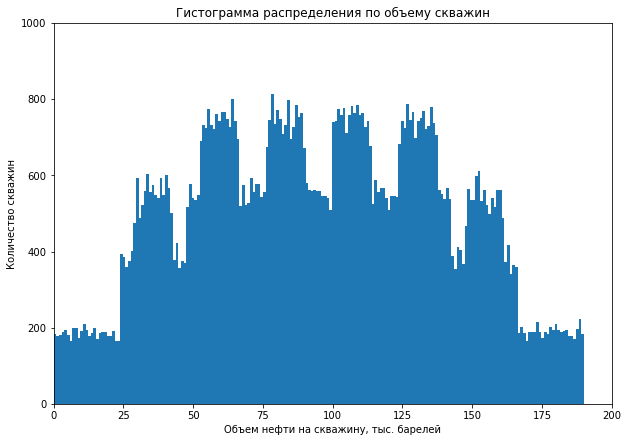

In [18]:
product_hist(geo_data_2['product'], 200, 200, 1000)

В регионах 0 и 2 наблюдается нормальное распределение, в то время как в регионе 1 оно выглядит странно. 10000 значение распределениы равномерно, скорее всего данные искуственные

Корреляция признаков

In [19]:
geo_data_0.corr()

,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


In [20]:
geo_data_1.corr()

,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


In [21]:
geo_data_2.corr()

,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


С корреляцией всё в порядке

### Вывод

- Пропуски отсутствуют
- Дубликаты отсутствуют
- Нулевые значения выявлены
- Целевой признак выявлен
- Распределение изучено
- Корреляция изучена

**Данные подготовлены**

## Обучение и проверка модели

Вывод предсказанного моделью запаса нефти и RMSE

In [21]:
model = LinearRegression()

def oil_predict(df, target_name):
    features = df.drop([target_name] , axis=1)
    target = df[target_name]
    
    features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE)
    
    model.fit(features_train, target_train)
    predicted_target = model.predict(features_valid)
    data = {'real_product' : target_valid,'predicted_product' : predicted_target}
    data_frame = pd.DataFrame(data, columns = ['real_product', 'predicted_product'])
    rmse = mean_squared_error(target_valid, predicted_target)**0.5
    mean = data_frame['predicted_product'].mean()
    oil_sum = data_frame['predicted_product'].sum()
    return data_frame, rmse, mean, oil_sum

In [22]:
geo_data_0_predicted, geo_data_0_rmse, geo_data_0_predicted_mean, geo_data_0_predicted_sum = oil_predict(geo_data_0, 'product')
print(geo_data_0_predicted.head())
print('RMSE:', geo_data_0_rmse)
print('Средний запас нефти:', geo_data_0_predicted_mean)

       real_product  predicted_product
71751     10.038645          95.894952
80493    114.551489          77.572583
2655     132.603635          77.892640
53233    169.072125          90.175134
91141    122.325180          70.510088
RMSE: 37.5794217150813
Средний запас нефти: 92.59256778438035


In [23]:
geo_data_1_predicted, geo_data_1_rmse, geo_data_1_predicted_mean, geo_data_1_predicted_sum = oil_predict(geo_data_1, 'product')
print(geo_data_1_predicted.head())
print('RMSE:', geo_data_1_rmse)
print('Средний запас нефти:', geo_data_1_predicted_mean)

       real_product  predicted_product
71751     80.859783          82.663314
80493     53.906522          54.431786
2655      30.132364          29.748760
53233     53.906522          53.552133
91141      0.000000           1.243856
RMSE: 0.893099286775617
Средний запас нефти: 68.728546895446


In [24]:
geo_data_2_predicted, geo_data_2_rmse, geo_data_2_predicted_mean, geo_data_2_predicted_sum = oil_predict(geo_data_2, 'product')
print(geo_data_2_predicted.head())
print('RMSE:', geo_data_2_rmse)
print('Средний запас нефти:', geo_data_2_predicted_mean)

       real_product  predicted_product
71751     61.212375          93.599633
80493     41.850118          75.105159
2655      57.776581          90.066809
53233    100.053761         105.162375
91141    109.897122         115.303310
RMSE: 40.02970873393434
Средний запас нефти: 94.96504596800489


### Вывод

**Лучше всего модель предсказала в регионе 0, далее регион 2. Хуже всего себя показал регион 1, как по показателю RMSE так и по среднему запасу нефти**

## Подготовка к расчёту прибыли

Безубыточная разработка сырья

In [25]:
no_damage_point = (BUDGET / BEST_POINTS)  / PRICE_PER_BARREL
print('Объём безубыточной разработки -',no_damage_point, 'тыс. барелей')

Объём безубыточной разработки - 111.11111111111111 тыс. барелей


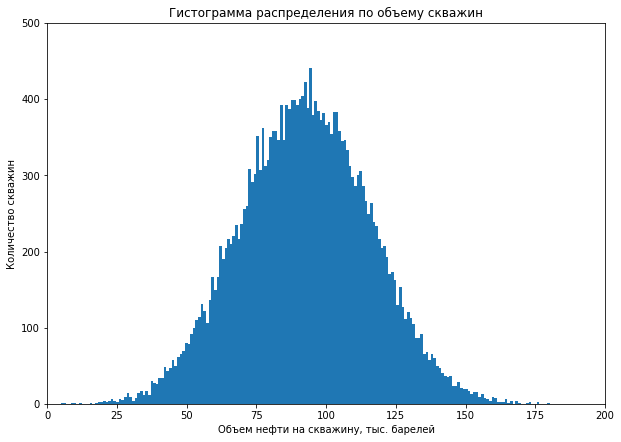

,real_product,predicted_product
count,25000.000000,25000.000000
mean,92.078597,92.592568
std,44.286913,23.176994
min,0.004022,-9.367846
25%,56.059494,76.652232
50%,90.897664,92.661884
75%,128.160698,108.437632
max,185.315412,180.180713


In [26]:
product_hist(geo_data_0_predicted['predicted_product'], 200, 200, 500)
geo_data_0_predicted.describe()

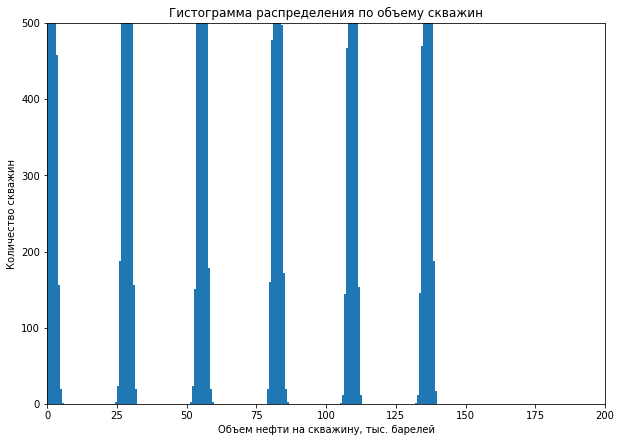

,real_product,predicted_product
count,25000.000000,25000.000000
mean,68.723136,68.728547
std,46.022165,46.010225
min,0.000000,-1.893774
25%,26.953261,28.536661
50%,57.085625,57.851586
75%,107.813044,109.346485
max,137.945408,139.818970


In [27]:
product_hist(geo_data_1_predicted['predicted_product'], 200, 200, 500)
geo_data_1_predicted.describe()

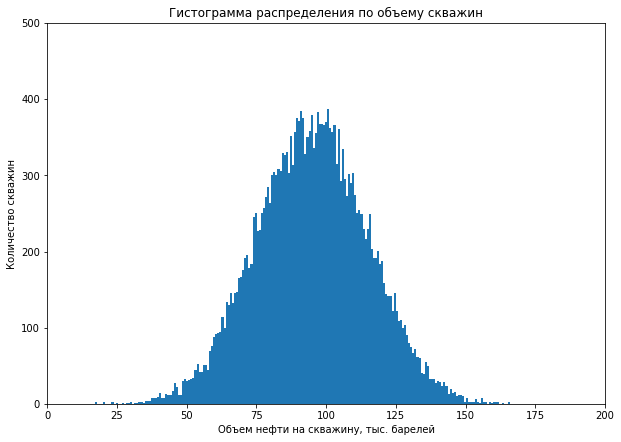

,real_product,predicted_product
count,25000.000000,25000.000000
mean,94.884233,94.965046
std,44.902982,19.853733
min,0.000000,17.131597
25%,59.217876,81.388500
50%,94.979468,95.031204
75%,130.568416,108.492663
max,190.010982,165.856833


In [28]:
product_hist(geo_data_2_predicted['predicted_product'], 200, 200, 500)
geo_data_2_predicted.describe()

Объем для безубыточной работы региона составляет 111.11 тыс. баррелей. Ни один из регионов не подходит по ожидаемому среднему запасу, однако в каждом регионе есть определенная доля точек, в которых значение выше 111.11. То есть можно попасть как в хорошую точку, так и плохую.

**Для того, чтоб выявить риски работы в регионе и оценить потенциальную прибыль, мы применяем технику бутстрапирования**

**Функция для расчета прибыли**

In [29]:
def oil_profit_calculation(target, probabilities, count):
    probabilities_sorted = probabilities.sort_values(ascending=False)
    selected = target[probabilities_sorted.index][:count]
    return PRICE_PER_BARREL * selected.sum() - BUDGET

### Вывод

**Выявлен объем безубыточной обработки сырья который равен 111.11 тыс. баррелей**

**Составлена функция для расчета прибыли**

**Далее применим технику бутстрапа для оценки рисков и прибыли**

## Расчёт прибыли и рисков 

In [30]:
state = np.random.RandomState(RANDOM_STATE)
def bootstrap_1000(target, probabilities):
    values=[]
    lost = 0
    for i in range(1000):
        target_sample = target.sample(replace=True, random_state=state, n=POINTS)
        probabilities_sample = probabilities[target_sample.index]
        profit = oil_profit_calculation(target, probabilities_sample, BEST_POINTS)
        if profit < 0:
            lost +=1
        values.append(profit)
    
    values = pd.Series(values)
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    average = values.mean()
    risk = lost / 1000
    return average, lower, upper, risk

In [31]:
average_0, lower_0, upper_0, risk_0 = bootstrap_1000(geo_data_0_predicted['real_product'], 
                                                     geo_data_0_predicted['predicted_product'])
print('Данные по региону 0.')
print('Средняя прибыль по региону = {:.2f} тыс.руб.'.format(average_0))
print('95% доверительный интервал от {:.2f} до {:.2f} тыс.руб.'.format(lower_0, upper_0))
print('Процент риска {:.2%}'.format(risk_0))

Данные по региону 0.
Средняя прибыль по региону = 396164.98 тыс.руб.
95% доверительный интервал от -111215.55 до 909766.94 тыс.руб.
Процент риска 6.90%


In [32]:
average_1, lower_1, upper_1, risk_1 = bootstrap_1000(geo_data_1_predicted['real_product'], 
                                                     geo_data_1_predicted['predicted_product'])
print('Данные по региону 1.')
print('Средняя прибыль по региону = {:.2f} тыс.руб.'.format(average_1))
print('95% доверительный интервал от {:.2f} до {:.2f} тыс.руб.'.format(lower_1, upper_1))
print('Процент риска {:.2%}'.format(risk_1))

Данные по региону 1.
Средняя прибыль по региону = 461155.82 тыс.руб.
95% доверительный интервал от 78050.81 до 862952.06 тыс.руб.
Процент риска 0.70%


In [33]:
average_2, lower_2, upper_2, risk_2 = bootstrap_1000(geo_data_2_predicted['real_product'], 
                                                     geo_data_2_predicted['predicted_product'])
print('Данные по региону 2.')
print('Средняя прибыль по региону = {:.2f} тыс.руб.'.format(average_2))
print('95% доверительный интервал от {:.2f} до {:.2f} тыс.руб.'.format(lower_2, upper_2))
print('Процент риска {:.2%}'.format(risk_2))

Данные по региону 2.
Средняя прибыль по региону = 392950.48 тыс.руб.
95% доверительный интервал от -112227.63 до 934562.91 тыс.руб.
Процент риска 6.50%


### Вывод

В соответствии с проведенным исследованием по заданному условием уровню риска для разработки подходит регион 1.

У данного региона самый низкий риск в 0.7% и самая высокая средняя прибыль 461155.82 тыс.руб.

Ниже приведены данные для сравнения регионов

Данные по региону 0.
Средняя прибыль по региону = 396164.98 тыс.руб.
95% доверительный интервал от -111215.55 до 909766.94 тыс.руб.
Процент риска 6.90%

**Данные по региону 1.
Средняя прибыль по региону = 461155.82 тыс.руб.
95% доверительный интервал от 78050.81 до 862952.06 тыс.руб.
Процент риска 0.70%**

Данные по региону 2.
Средняя прибыль по региону = 392950.48 тыс.руб.
95% доверительный интервал от -112227.63 до 934562.91 тыс.руб.
Процент риска 6.50%